# Title TBD:

(c) 2020 Manuel Razo & Daniela Osorio. This work is licensed under a 
[Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). 
All code contained herein is licensed under an 
[MIT license](https://opensource.org/licenses/MIT).

In [1]:
import glob

# Numerical analysis libraries
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr

# Interface to Stan
import cmdstanpy
import arviz as az

# Find home directory for repo
import git
repo = git.Repo("./", search_parent_directories=True)
homedir = repo.working_dir

# Import plotting features
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set_style("ticks")
sns.set_palette("colorblind", color_codes=True)
sns.set_context("paper")

# Magic command to plot inline
%matplotlib inline

#To graph in SVG (high def)
%config InlineBackend.figure_format="svg"


Bad key "text.kerning_factor" on line 4 in
/Users/mrazomej/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


## Explanation of what we are doing here (by Daniela)

Explanation goes here...

### Exploratory Data Analysis

Before jumping into the analysis let's do a quick exploration of the data. First, we need to import the data form all enzymes into memory.

In [2]:
# List files to be read
files = glob.glob(f"{homedir}/data/processed/enzymes/*csv")

# Read all files into dataframe
df = pd.concat(map(pd.read_csv, files))
# Remove unnecessary column
df = df.drop('Unnamed: 0', axis=1)

# Print unique enzymes
print(f"enzymes: {df.Name.unique()}")
df.head()

enzymes: ['DddD' 'DddP' 'DddK' 'Alma1' 'DmdA' 'DddY' 'DddQ']


,Name,d34S,Replicate,Time_min,ID,f_R,Real_conc,minus_ln_f_R,d34S_approx,r34_approx,f34_approx,conc_s_cell_lysate,F34_approx_DMSP,R34_approx_DMSP,d34S_approx_DMSP
0,DddD,12.410000,b,0,DddD_0_b,1.000000,95.300000,0.000000,12.333627,0.045560,0.043574,37.508476,0.043645,0.045637,14.044276
1,DddD,11.498627,b,4,DddD_4_b,0.721417,68.750996,0.326539,11.433021,0.045519,0.043537,37.508476,0.043615,0.045604,13.312725
2,DddD,13.121328,b,11,DddD_11_b,0.497228,47.385801,0.698707,13.035989,0.045591,0.043603,37.508476,0.043768,0.045771,17.032980
3,DddD,12.707020,b,18,DddD_18_b,0.303706,28.943204,1.191694,12.626963,0.045573,0.043586,37.508476,0.043834,0.045843,18.640973
4,DddD,12.973279,b,25,DddD_25_b,0.241314,22.997230,1.421656,12.889847,0.045585,0.043597,37.508476,0.043926,0.045945,20.888524


Having imported the data, let's look at the plot of (Dani) (column `minus_ln_f_R`) vs. (Dani) (col `d34S_approx_DMSP`)

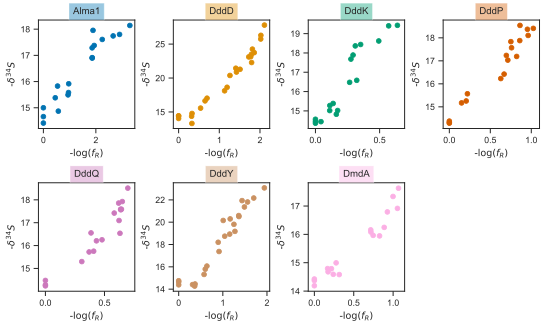

In [3]:
# Group data by enzyme
df_group = df.groupby("Name")

# Define colors
colors = sns.color_palette("colorblind", n_colors=len(df_group))
# Initialize figure
fig, ax = plt.subplots(2, 4, figsize=(9, 5))

# ravel ax
ax = ax.ravel()

# Loop through enzymes
for i, (enzyme, data) in enumerate(df_group):
    # Plot minus_ln_f_R vs d34S_approx_DMSP
    ax[i].scatter(data["minus_ln_f_R"], data["d34S_approx_DMSP"], color=colors[i])
    
    # Set plot title
    ax[i].set_title(f"{enzyme}", bbox=dict(facecolor=colors[i], alpha=0.4))
    
    # Set axis labels
    ax[i].set_xlabel(r"-$\log (f_R)$")
    ax[i].set_ylabel(r"-$\delta ^{34}S$")
    
# Increase spacing among subplots
plt.subplots_adjust(hspace=0.5, wspace=0.4)

# Remove last plot
ax[-1].axis("off");

We can see that, as expected, there is a linear correlation between (Dani) and (Dani). In order to compute the (Dani, fractionation factor?) we then need to estimate the slope of this linear regression. This, being one of the main results of our work, deserves a careful analysis. Therefore, rather than performing a simple ordinary least-squares or even a maximum likelihood estimate, we will perform a Bayesian linear regression to obtain this slope.

## Bayesian linear regression.

In Bayesian parameter inference we are concerned with learning the probability distribution over the quantities that parametrize our models. For the particular case of this linear regression let us define $x \equiv \log(f_R)$ and $y \equiv -\delta S^{34}$. Our simple linear regression model then takes the form of
$$
y_i = m x_i + b + \varepsilon_i,
$$
where $m$ is the slope we are interested in, $b$ is the $y-$axis intercept, and $\varepsilon_i$ is a random error associated with the intrinsic experimental errors. We take these errors to be random, i.e., we can only describe them probabilistically. As it is commonly done, we will assume that these errors are normally distributed, i.e.,
$$
\varepsilon_i = y_i - (m x_i + b) \sim \mathcal{N}(0, \sigma^2).
$$
What this equation is telling us is that we expect the random errors to have a mean of zero (positive and negative errors are equally likely, canceling each other), and they are characterized by an unknown variance $\sigma^2$.

So the objective of our Bayesian regression is to compute the so-called posterior probability distribution $P(m, b, \sigma^2 \mid D)$, where $D \equiv \{x_1, x_2, \ldots, x_N \}$, is the data. We can then write Bayes theorem as
$$
P(m, b, \sigma^2 \mid D) = \frac{P(D \mid m, b, \sigma^2)P(m, b, \sigma^2)}{P(D)}
\propto P(D \mid m, b, \sigma^2)P(m, b, \sigma^2).
$$
For the second equality we ignore the denominator $P(D)$ since it does not depend on our parameter values, and therefore only serves as a normalization constant.

Let's now analyze the two relevant terms.

### The likelihood $P(D \mid m, b, \sigma^2)$

The likelihood term, called like this because it reflects how likely it is to observe our data $D$ given a particular choice of parameter values $m, b$, and $\sigma^2$, is what ...

### Marginal probability distribution of slope $P(m \mid D)$

$$
m \mid y_{1}, \cdots, y_{n} \sim \mathrm{t}\left(n-2, \hat{m}, \frac{\hat{\sigma}^{2}}{\mathrm{S}_{x x}}\right)
$$

$$
b \mid y_{1}, \cdots, y_{n} \sim \mathrm{t}\left(n-2, \hat{b}, \hat{\sigma}^{2}\left(\frac{1}{n}+\frac{\bar{x}^{2}}{\mathrm{S}_{x x}}\right)\right)
$$

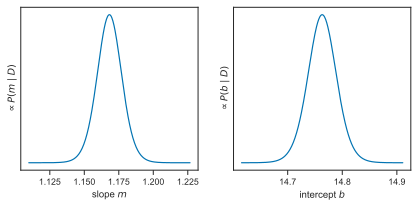

In [4]:
# Select example dataframe
df_example = df[df.Name == "Alma1"]

# Extract x and y data
x = df_example["minus_ln_f_R"]
y = df_example["d34S_approx_DMSP"]

# Fit 1D polynomial with numpy
# This is equivalent to finding the mean of the distribution
m_hat, b_hat = np.polyfit(x, y, 1)

# Define distribution parameters
n = len(df_example)  # number of datum
d_freedom = n - 2  # Degrees of freedom
sigma_sq = np.sum((y - (m_hat * x + b_hat))**2) / d_freedom  # mean squared error
S_xx = np.sum((x - np.mean(x))**2)  # sum of squares

# Compute error for slope
m_err = sigma_sq / S_xx
# Compute error for intercept
b_err = sigma_sq * (1 / n + np.mean(x)**2 / S_xx)

# Define range to evaluate slope distribution
m_range = np.linspace(0.95 * m_hat, 1.05 * m_hat, 300)
# Evaluate distribution
m_pdf = sp.stats.t.pdf(m_range, d_freedom, m_hat, m_err)

# Define range to evaluate intercept distribution
b_range = np.linspace(0.99 * b_hat, 1.01 * b_hat, 300)
# Evaluate distribution
b_pdf = sp.stats.t.pdf(b_range, d_freedom, b_hat, b_err)

# Initialize figure
fig, ax = plt.subplots(1, 2, figsize=(7, 3))

# Plot slope distribution
ax[0].plot(m_range, m_pdf)
# Label axis
ax[0].set_xlabel(r"slope $m$")
ax[0].set_ylabel(r"$\propto P(m \mid D)$")
# Remove y axis ticks
ax[0].set_yticks([])

# Plot interecept distribution
ax[1].plot(b_range, b_pdf)
# Label axis
ax[1].set_xlabel(r"intercept $b$")
ax[1].set_ylabel(r"$\propto P(b \mid D)$")
# Remove y axis ticks
ax[1].set_yticks([])

# Adjust plot spacing
plt.subplots_adjust(wspace=0.2)

By eye, these distributions seem reasonable. Let's now compute the 95% **credible region** for both parameters

In [5]:
# Define percentiles
percentiles = [0.025, 0.975]

# Compute percentiles for slope
m_per = [sp.stats.t.ppf(x, d_freedom, m_hat, m_err) for x in percentiles]

# Compute percentiles for intercept
b_per = [sp.stats.t.ppf(x, d_freedom, b_hat, b_err) for x in percentiles]

# Print results
print(f"slope: {np.round(m_hat, 2)} + " +
      f"{np.round(m_per[1] - m_hat, 2)} - " +
      f"{np.round(m_hat - m_per[0], 2)}")

print(f"intercept: {np.round(b_hat, 2)} + " +
      f"{np.round(b_per[1] - b_hat, 2)} - " +
      f"{np.round(b_hat - b_per[0], 2)}")

slope: 1.17 + 0.02 - 0.02
intercept: 14.76 + 0.05 - 0.05


Let's then define a function that takes the data, and computes the percentiles for the slope, which is the quantity we care about.

In [6]:
def slope_regression(x, y, percentiles=[0.025, 0.05, 0.975]):
    """
    Function to compute the credible region of the slope "m" on a
    linear regression of the form y_i = m * x_i + b.
    Parameters
    ----------
    x : array-like
        x-values of the linear regression
    y : array-like
        y-values of linear regression
    percentiles : array-like. Default = [0.025, 0.05, 0.975]
        Percentiles of the posterior distribution to be computed
    Returns
    -------
    slope_percentiles : array-like
        Percentiles of the posterior distribution for the slope
    """
    # Fit 1D polynomial with numpy
    # This is equivalent to finding the mean of the distribution
    m_hat, b_hat = np.polyfit(x, y, 1)

    # Define distribution parameters
    n = len(x)  # number of datum
    d_freedom = n - 2  # Degrees of freedom
    sigma_sq = np.sum((y - (m_hat * x + b_hat))**2) / d_freedom  # mean squared error
    S_xx = np.sum((x - np.mean(x))**2)  # sum of squares

    # Compute error for slope
    m_err = sigma_sq / S_xx

    # Compute percentiles for slope
    return [sp.stats.t.ppf(x, d_freedom, m_hat, m_err) for x in percentiles]

Let's now evaluate the regression for all enzymes.

In [7]:
# Group data by enzyme
df_group = df.groupby("Name")

# Define percentles to compute
percentiles = [0.025, 0.5, 0.975]

# Initialize dataframe to save slope inferences
df_slope = pd.DataFrame(
    [], columns=["enzyme", "slope_min", "slope_mode", "slope_high"]
)

# Loop through enzymes
for enzyme, data in df_group:
    # Extract x and y data
    x = data["minus_ln_f_R"]
    y = data["d34S_approx_DMSP"]
    # Compute regression
    reg = slope_regression(x, y, percentiles)
    # Append to dataframe
    df_slope = df_slope.append(
        pd.Series([enzyme] + reg, index=df_slope.columns),
        ignore_index=True
    )

df_slope

,enzyme,slope_min,slope_mode,slope_high
0,Alma1,1.149526,1.168205,1.186884
1,DddD,5.788309,5.973506,6.158703
2,DddK,7.627873,9.088253,10.548632
3,DddP,3.865322,3.984789,4.104257
4,DddQ,4.850229,5.261780,5.673331
5,DddY,4.902735,5.092851,5.282968
6,DmdA,2.646655,2.712483,2.778311


## Plotting regression credible region

$$
y_{n+1} \mid \text { data, } x_{n+1} \sim \mathrm{t}\left(n-2, \hat{\alpha}+\hat{\beta} x_{n+1}, \mathrm{S}_{Y \mid X_{n+1}}^{2}\right)
$$
where
$$
\mathrm{S}_{Y \mid X_{n+1}}^{2}=\hat{\sigma}^{2}+\hat{\sigma}^{2}\left(\frac{1}{n}+\frac{\left(x_{n+1}-\bar{x}\right)^{2}}{\mathrm{S}_{x x}}\right)=\hat{\sigma}^{2}\left(1+\frac{1}{n}+\frac{\left(x_{n+1}-\bar{x}\right)^{2}}{\mathrm{S}_{x x}}\right)
$$

(Text(0, 0.5, '-$\\delta ^{34}S$'),)

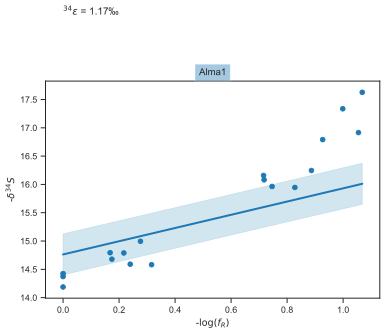

In [8]:
# Define range of x values to evaluate
x_range = np.linspace(x.min(), x.max(), 200)

# Compute parameters for prediction distributions
y_hat = m_hat * x_range + b_hat
S_yx = sigma_sq * (1 + 1 / n + (x_range - np.mean(x))**2 / S_xx)

# Compute percentiles
y_low = sp.stats.t.ppf(0.025, d_freedom, y_hat, S_yx)
y_high = sp.stats.t.ppf(0.975, d_freedom, y_hat, S_yx)
y_mode = sp.stats.t.ppf(0.5, d_freedom, y_hat, S_yx)

# Define colors
colors=sns.color_palette("Paired", n_colors=2)

# Plot regression
plt.fill_between(x_range, y_low, y_high, alpha=0.5, color=colors[0])
plt.plot(x_range, y_mode, lw=2, color=colors[1])

# Plot data
plt.scatter(x, y, color=colors[1])

# Set plot title
plt.title(f"Alma1", bbox=dict(facecolor=colors[1], alpha=0.4))

# Add text
plt.text(0, 19, r"$^{34}\varepsilon$ = " + f"{np.round(m_hat,2)}‰")

# Set axis labels
plt.xlabel(r"-$\log (f_R)$")
plt.ylabel(r"-$\delta ^{34}S$"),

This looks great. Just as before, let's define a function that computes this confidence interval so that we can reproduce this analysis for all enzymes

In [9]:
def credible_region(x, y, percentiles=[0.025, 0.05, 0.975], n_points=100):
    """
    Function to compute the credible region of the regression of a
    linear regression of the form y_i = m * x_i + b.
    Parameters
    ----------
    x : array-like
        x-values of the linear regression
    y : array-like
        y-values of linear regression
    percentiles : array-like. Default = [0.025, 0.05, 0.975]
        Percentiles of the posterior distribution to be computed
    n_points : int. Default = 100
        Number of points to include in analysis.
    Returns
    -------
    regression percentile : array-like
        Percentiles of the posterior distribution for the linear regression
    """
    # Fit 1D polynomial with numpy
    # This is equivalent to finding the mean of the distribution
    m_hat, b_hat = np.polyfit(x, y, 1)

    # Define distribution parameters
    n = len(x)  # number of datum
    d_freedom = n - 2  # Degrees of freedom
    sigma_sq = np.sum((y - (m_hat * x + b_hat))**2) / d_freedom  # mean squared error
    S_xx = np.sum((x - np.mean(x))**2)  # sum of squares

    # Define range of x values to evaluate
    x_range = np.linspace(x.min(), x.max(), n_points)

    # Compute parameters for prediction distributions
    y_hat = m_hat * x_range + b_hat
    S_yx = sigma_sq * (1 + 1 / n + (x_range - np.mean(x))**2 / S_xx)

    # Initialize array to save percentiles
    per = np.zeros([n_points, len(percentiles) + 1])
    # Add x values to first column
    per[:, 0] = x_range
    
    # Loop through percentiles
    for i, p in enumerate(percentiles):
        # Compute percentiles
        per[:, i + 1] = sp.stats.t.ppf(p, d_freedom, y_hat, S_yx)
    
    # Compute percentiles for slope
    return per

Let's now apply the regression to all enzymes.

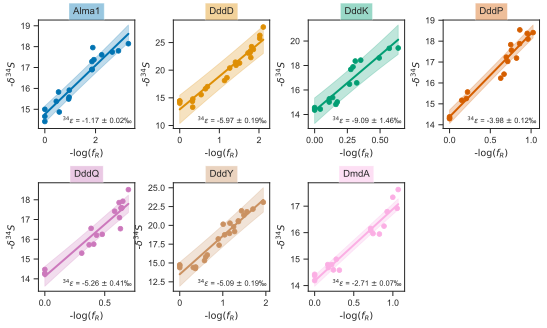

In [10]:
# Group data by enzyme
df_group = df.groupby("Name")

# Define colors
colors = sns.color_palette("colorblind", n_colors=len(df_group))
# Initialize figure
fig, ax = plt.subplots(2, 4, figsize=(9, 5))

# ravel ax
ax = ax.ravel()

# Loop through enzymes
for i, (enzyme, data) in enumerate(df_group):
    # Extract x and y data
    x = data["minus_ln_f_R"]
    y = data["d34S_approx_DMSP"]
    # Compute regression for slope
    m_reg = slope_regression(x, y, percentiles)
    
    # Compute credible region for linear regression
    lin_reg = credible_region(x, y, percentiles, 100)
    
    # Plot regression 
    # Plot regression
    ax[i].fill_between(
        lin_reg[:, 0], lin_reg[:, 1], lin_reg[:, 3], alpha=0.25, color=colors[i]
    )
    ax[i].plot(lin_reg[:, 0], lin_reg[:, 2], lw=2, color=colors[i])
    
    # Plot minus_ln_f_R vs d34S_approx_DMSP
    ax[i].scatter(x, y, color=colors[i])
    
    # Set plot title
    ax[i].set_title(f"{enzyme}", bbox=dict(facecolor=colors[i], alpha=0.4))
    
    # Add fractionation factor
    ax[i].text(
        0.25,
        0.05,
        r"$^{34}\varepsilon$ = " + f"{np.round(-m_reg[1],2)} $\pm$ {np.round(m_reg[1] - m_reg[0],2)}‰",
        transform = ax[i].transAxes,
        fontsize=7.5,
    )
    # Set axis labels
    ax[i].set_xlabel(r"-$\log (f_R)$")
    ax[i].set_ylabel(r"-$\delta ^{34}S$")
    
# Increase spacing among subplots
plt.subplots_adjust(hspace=0.5, wspace=0.4)

# Remove last plot
ax[-1].axis("off");

## Substrate degradation kinetics

Explanation for why this goes here...

### Exploratory Data Analysis

As in the previous section, let's first take a look at all of the data.

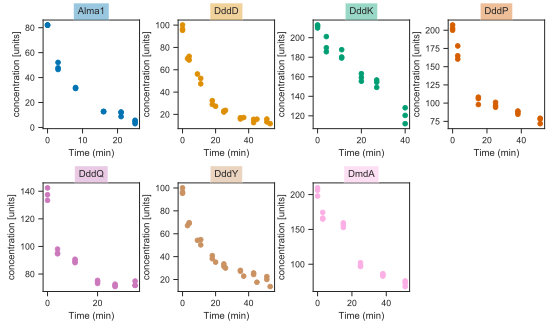

In [11]:
# Group data by enzyme
df_group = df.groupby("Name")

# Define colors
colors = sns.color_palette("colorblind", n_colors=len(df_group))
# Initialize figure
fig, ax = plt.subplots(2, 4, figsize=(9, 5))

# ravel ax
ax = ax.ravel()

# Loop through enzymes
for i, (enzyme, data) in enumerate(df_group):
    # Plot minus_ln_f_R vs d34S_approx_DMSP
    ax[i].scatter(data["Time_min"], data["Real_conc"], color=colors[i])
    
    # Set plot title
    ax[i].set_title(f"{enzyme}", bbox=dict(facecolor=colors[i], alpha=0.4))
    
    # Set axis labels
    ax[i].set_xlabel(r"Time (min)")
    ax[i].set_ylabel(r"concentration [units]")
    
# Increase spacing among subplots
plt.subplots_adjust(hspace=0.5, wspace=0.4)

# Remove last plot
ax[-1].axis("off");

We can see a whole myriad of behaviors from the enzymes. Most of them seem to progress as expected, but others such as *DddP* go through two different phases. We will analyze these kinetics assuming the simples possible model.

## Irreversible enzyme kinetics

In order to make sense of this data let's try to fit the simplest possible model that accounts for the enzyme kinetics. For this we will make the explicit assumption that there is no reversibility in our enzymatic reactions. What this means is that at all points we can assume that the rate at which the substrate is degraded is given by the rate of product production. This is given by
$$
\frac{dS}{dt} = -\frac{V_\max S}{K_M + S},
$$
where $S$ is the substrate concentration, $t$ is time, $V_\max$ is the maximum catalytic activity when the enzyme is saturated, and $K_M$ is the Michaelis-Menten constant. Our task is then to infer the value of both parameters, $V_\max$ and $K_M$. For this we will again use a Bayesian inference approach

### Bayesian inference of enzyme kinetics

As just mentioned, our task is to compute the probability distribution of both parameter values of our simple enzyme kinetics model. In terms of Bayes theorem this is written as
$$
P(V_\max, K_M \mid D) \propto P(D \mid V_\max, K_M) P(V_\max, K_M),
$$
where $D$ are the time points at which the substrate concentration was measured. Let's looks into each of the terms.

#### Likelihood $P(D \mid V_\max, K_M)$

The first thing we need to distinguish is our theoretical expectation of the substrate concentration $S$, and the actual experimental measurement that we will define as $\tilde{S}$. The differential equation we wrote before for the substrate concentration is a **deterministic** model. That means that for any given input $S$ it can only compute one output. Our likelihood function should then account for the expected deviations that our measurements $\tilde{S}$ will have with respect to the theoretical expectations $S$. As is commonly done in practice, we will define the likelihood to be a Gaussian distribution with mean around the theoretical expectation, and standard deviation $\sigma^2$. This is written as
$$
\tilde{S}(t) \sim \mathcal{N}(S(t), \sigma^2),
$$
where $S(t)$ is given by
$$
S(t) = \int_0^t dt \; \frac{dS}{dt} = -\int_0^t dt \; \frac{V_\max S}{K_M + S}.
$$
In other words, we assume that our experimental measurement of the substrate concentration at time $t$ $\tilde{S}(t)$ will depart from the expected theoretical prediction $S(t)$ with a characteristic distance $\sigma^2$. This theoretical prediction at time $t$ is then computed by integrating the differential equation from time zero to the indicated time. Given that we do not have a closed-form solution for this integral, we well then use numerical integration to compute this expected quantity.

Furthermore, we will assume that each of the measurements in our dataset $D = \{\tilde{S}_0, \tilde{S}_1, \ldots, \tilde{S}_N \}$ are independent. This means that our likelihood then takes the explicit form
$$
P(D \mid V_\max, K_M, \sigma^2) = \prod_{i=1}^N P(\tilde{S}_i \mid V_\max, K)
= \prod_{i=1}^N \frac{1}{\sqrt{2 \pi \sigma^2}} \exp\left[ - \frac{(\tilde{S}_i - S_i)^2}{2 \sigma^2} \right],
$$
where we added the term $\sigma^2$ to the likelihood since this nuance parameter needs to be included in the analysis.

#### Prior $P(V_\max, K_M, \sigma^2)$

For our prior we will first assume that all three parameters are independent of each other, i.e.
$$
P(V_\max, K_M, \sigma^2) = P(V_\max) P(K_M) P(\sigma^2).
$$
Since we do not have any particular prior information about the maximum catalytic speed for these enzymes, we will take the simplest approach of assuming a uniform prior for $V_\max$. This is
$$
P(V_\max) = \frac{1}{V_\max^{(\max)} - V_\max^{(\min)}},
$$
where $V_\max^{(\min)}$ and $V_\max^{(\max)}$ are some boundaries (for example we know there cannot be negative catalytic activities, so $V_\max^{(\min)} \geq 0$.

For the Michaelis-Menten constant we actually have information. Several work in the literature (Dani, I would probably add the references at the end of the notebook) has characterized this parameter for the enzymes. We will then use an informative prior for $K_M$. More specifically we will assume that $K_M$ has a Gaussian prior of the form
$$
K_M \sim \mathcal{N}(\mu_{K_M}, \sigma^2_{K_M}),
$$
where $\mu_{K_M}$ and $\sigma^2_{K_M}$ are the values of the mean and variance reported in the references, respectively. **Note**: Not all enzymes have a reported variance. For those we will use a rule of thumb assuming $\approx$ 10\% error in the measurements.

Finally for the observation error $\sigma^2$ we will assume a half-Normal prior. This prior has the advantage compared to the Jeffreys' prior used in the previous section that it helps our sampler work properly. We chose a half-Normal distribution to allow the error to be arbitrarily close to zero without going into the forbidden negative values.

## Setting up the MCMC sampler

The posterior distribution for this problem differs from the one in the linear regression in one key aspect: There is not know closed-form solution to this likelihood. We therefore do not have a clean equation that we can easily compute in order to infer the parameters. We then will use the state-of-the-art Markov Chain Monte Carlo sampler [`Stan`](https://mc-stan.org/users/documentation/). `Stan` implements an efficient Hamiltonian Monte Carlo sampler, allowing us to approximate numerically the posterior distribution. Since `Stan` uses compiled `C++` code it runs extremely fast. The downfall is that one has to use `Stan`'s native syntax in order to run the code. But we think that this is a small price to pay compared to the performance enhancement.

In the directory `stan_files` we have a file `michaelis_menten_inference.stan` that performs the sampling. This file requires the following inputs:
```
// Inference information
int<lower=1> n_sample;  // number of time samples
real t_sample[n_sample];  // time points observed
real s_[n_sample];  // data, substrate concentration
real<lower=0> s0;  // Initial substrate concentration
real<lower=0> t0;  // Initial time

//  Simulation information
int<lower=1> n_sim;  // number of time points for numerical integration
real t_sim[n_sim];  // time points for numerical integration

// Parameters for prior distributions
real vmax_param[2];  // parameters for prior dis. of V_max
real km_param[2];  // parameters for prior dis. of K_M
real sigma_param[2];  // parameters for prior dis. of sigma^2
```

Let's compile this into a dictionary

In [39]:
data  = {
    "n_sample": len(df_example),
    "t_sample": df_example.Time_min.values,
    "s_": df_example.Real_conc.values,
    "s0": df_example.Real_conc[0],
    "t0": df_example.Time_min[0],
    "n_sim": 500,
    "t_sim": np.linspace(
        df_example.Time_min.min(), df_example.Time_min.max(), 500
    ),
    "vmax_param": [0, 40],
    "km_param": [9000, 900],
    "sigma_param": [0, 1],
}

Now we are ready to compile the `Stan` script.

In [40]:
sm = cmdstanpy.CmdStanModel(stan_file='stan_files/michaelis_menten_inference.stan')

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /Users/mrazomej/git/DMSP/code/analysis/stan_files/michaelis_menten_inference


Having compiled the script, let's go ahead and sample.

In [43]:
# Define initial conditions
samples = sm.sample(
    data=data,
    chains=6,
    iter_warmup=1500,
    iter_sampling=1500,
)

# Convert samples to ArViz object
samples_post = az.from_cmdstanpy(posterior=samples)

OverflowError: Maximum recursion level reached

In [ ]:
#Define parameters for the Michaelis-Menten kinetics 

#Create dataframe the Michaelis-Menten constant of different enzymes 
km = OrderedDict([ ('enzyme', ['Alma1', 'DddY', 'DddD', 'DmdA', 'DddP', 'DddK', 'DddQ']),
          ('km', [9000, 850, '>40000', 5400, 13800, 13600, 22000]),
                ('sd_km', [900, '', 12, 2300, 5500,'','']) ])
df_km = pd.DataFrame.from_dict(km)
df_km